In [1]:
import sys
sys.path.insert(1, '/ai/gno/CODE/DiffSR/')

import yaml
import torch
import matplotlib.pyplot as plt
import os.path as osp

from trainers import *
from datasets import NavierStokes2DDataset

from matplotlib.patches import Ellipse
import numpy as np

from tqdm import tqdm

In [2]:
ns_set = NavierStokes2DDataset(
    data_path="/ai/gno/DATA/ns/ns_V1e-5_N1200_T20.mat",
    sample_factor=[2,2],
    in_t=1,
    out_t=1,
    duration_t=10,
    train_batchsize=1,
    eval_batchsize=1,
    train_ratio=0.8,
    valid_ratio=0.1,
    test_ratio=0.1,
    normalize=True,
    normalizer_type='PGN',
)

Loading processed data from  /ai/gno/DATA/ns/ns_V1e-5_N1200_T20_processed.pt


In [ ]:
fno_dir = '/ai/gno/CODE/DiffSR/logs/NavierStokes2D/09_09/FNO2d_11_53_49'
fno_args_path = osp.join(fno_dir, 'config.yaml')
fno_args = yaml.load(open(fno_args_path, 'r'), Loader=yaml.FullLoader)

fno_trainer = FNO2DTrainer(fno_args)
fno = fno_trainer.load_model(fno)
fno = fno.cuda()
fno.eval()

FNO2d(
  (fc0): Linear(in_features=3, out_features=16, bias=True)
  (sp_convs): ModuleList(
    (0-3): 4 x SpectralConv2d()
  )
  (ws): ModuleList(
    (0): Conv1d(16, 24, kernel_size=(1,), stride=(1,))
    (1): Conv1d(24, 24, kernel_size=(1,), stride=(1,))
    (2): Conv1d(24, 32, kernel_size=(1,), stride=(1,))
    (3): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
  )
  (up_sp_conv): SpectralUpsampleConv2d()
  (up_ws): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

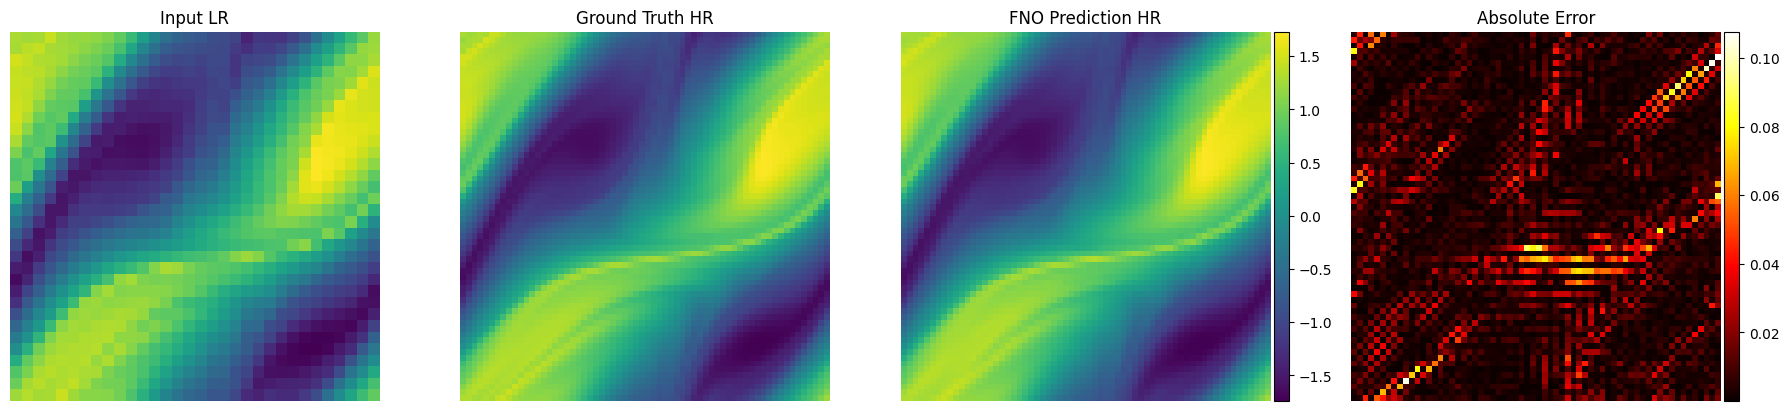

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


vis_x = ns_set.test_dataset.x[28:29]
vis_y = ns_set.test_dataset.y[28:29]
raw_y = ns_set.test_dataset.y_normalizer.decode(vis_y.view(1, -1, 1)).detach().cpu().reshape(64, 64)
raw_x = raw_y[::2, ::2]

pred_y = fno(vis_x.cuda())
pred_y = ns_set.test_dataset.y_normalizer.decode(pred_y.view(1, -1, 1)).detach().cpu().reshape(64, 64)

error_y = torch.abs(pred_y - raw_y)

vmin = raw_y.min()
vmax = raw_y.max()

fig, axs = plt.subplots(1, 4, figsize=(18, 4), constrained_layout=True)

axs[0].imshow(raw_x, cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title('Input LR')
axs[0].axis('off')

axs[1].imshow(raw_y, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title('Ground Truth HR')
axs[1].axis('off')

heatmap = axs[2].imshow(pred_y, cmap='viridis', vmin=vmin, vmax=vmax)
axs[2].set_title('FNO Prediction HR')
axs[2].axis('off')

errormap = axs[3].imshow(error_y, cmap='hot')
axs[3].set_title('Absolute Error')
axs[3].axis('off')

for ax, mappable in [(axs[2], heatmap), (axs[3], errormap)]:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.04)  # 统一 size/pad
    fig.colorbar(mappable, cax=cax)
plt.show()